In [1]:
import abc
import os
import random

import scipy.stats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

random.seed(os.urandom(16))

In [2]:
class RandomVariable(abc.ABC):
    @abc.abstractmethod
    def generate(self) -> int | float:
        pass

    @abc.abstractmethod
    def generate_n(self, n: int) -> tuple[np.ndarray, np.ndarray]:
        pass

    def __call__(self, *args, **kwargs):
        return self.generate()


class DiscreteRandomVariable(RandomVariable, abc.ABC):
    @abc.abstractmethod
    def generate(self) -> int:
        pass

    def generate_n(self, n: int) -> tuple[np.ndarray, np.ndarray]:
        raw = np.array([self.generate() for _ in range(n)])
        values, counts = np.unique(raw, return_counts=True)
        return values, counts


class ContinuousRandomVariable(RandomVariable, abc.ABC):
    @abc.abstractmethod
    def generate(self) -> float:
        pass

    def generate_n(self, n: int) -> tuple[np.ndarray, np.ndarray]:
        raw = np.array([self.generate() for _ in range(n)])

        return np.histogram(raw, bins='sturges')

## Параметры

In [3]:
# Параметр лямбда для пуассоновской случайной переменной
LAMBDA_POISSON = 0.5
# Параметр лямбда для экспоненциальной случайной переменной
LAMBDA_EXP = 0.5
# Количество экспериментов
N = 10000
# Уровень значимости
ALPHA = 0.05

## Пуассоновская случайная переменная

In [4]:
class Poisson(DiscreteRandomVariable):
    def __init__(self, lambda_: float):
        self._lambda = lambda_

    @property
    def lambda_(self) -> float:
        return self._lambda

    @lambda_.setter
    def lambda_(self, value: float):
        self._lambda = value

    def generate(self) -> int:
        u = np.random.uniform(0, 1)
        i = 0
        f = p = np.exp(-self._lambda)
        while u >= f:
            p = self._lambda * p / (i + 1)
            f += p
            i += 1
        return i


In [5]:
@np.vectorize
def poisson_prob(lambda_: float, i: int) -> float:
    return np.exp(-lambda_) * (lambda_ ** i / np.math.factorial(i))

def chi2_poisson(values: np.ndarray, counts: np.ndarray) -> tuple[float, int, pd.DataFrame]:
    n = int(np.sum(counts))
    if n > 5:
        while counts[-1] < 5 and len(counts) > 2:
            counts[-2] += counts[-1]
            counts = counts[:-1]
            values = values[:-1]
    lambda_s = np.sum(values * counts) / n
    p = poisson_prob(lambda_s, values)
    ni = p * n
    delta_n = counts - ni
    delta_n2 = delta_n ** 2
    k = delta_n2 / ni
    table = pd.DataFrame({"i": values, "n_i": counts, "n'_i": ni, "n_i - n'_i": delta_n, "(n_i - n'_i)^2": delta_n2, "K": k}).reset_index(drop=True)
    df = len(values) - 2
    return float(np.sum(k)), df, table

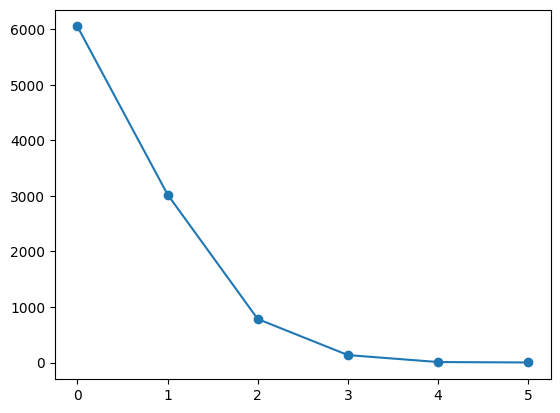

In [6]:
poisson = Poisson(LAMBDA_POISSON)
vals, c = poisson.generate_n(N)
plt.scatter(vals, c)
plt.plot(vals, c)

In [7]:
chi2, df, t = chi2_poisson(vals, c)
chi2_crit = scipy.stats.chi2.isf(ALPHA, df=df)
display(t)
print(f"chi2 = {chi2}")
print(f"df = {df}")
print(f"chi2_crit = {chi2_crit}")
print(f"Гипотезу {'принимаем' if chi2 < chi2_crit else 'отвергаем'}")

,i,n_i,n'_i,n_i - n'_i,(n_i - n'_i)^2,K
0,0,6049,6045.928637,3.071363,9.433269,0.001560
1,1,3024,3042.311290,-18.311290,335.303352,0.110213
2,2,783,765.445521,17.554479,308.159746,0.402589
3,3,134,128.390729,5.609271,31.463925,0.245064
4,4,10,16.151554,-6.151554,37.841613,2.342909


chi2 = 3.1023347139893946
df = 3
chi2_crit = 7.814727903251178
Гипотезу принимаем


## Экспоненциальная случайная переменная

In [8]:
class Exponential(ContinuousRandomVariable):
    def __init__(self, lambda_: float):
        self._lambda = lambda_

    @property
    def lambda_(self) -> float:
        return self._lambda

    @lambda_.setter
    def lambda_(self, value: float):
        self._lambda = value

    def generate(self) -> float:
        u = np.random.uniform(0, 1)
        return -1 / self._lambda * np.log(1 - u)


exponential = Exponential(LAMBDA_EXP)

In [9]:
@np.vectorize
def exp_prob(lambda_: float, start: float, end: float) -> float:
    return np.exp(-lambda_ * start) - np.exp(-lambda_ * end)

def chi2_exp(bins: np.ndarray, counts: np.ndarray) -> tuple[float, int, pd.DataFrame]:
    n = int(np.sum(counts))
    if n > 5:
        while counts[-1] < 5 and len(counts) > 2:
            counts[-2] += counts[-1]
            counts = counts[:-1]
            bins = bins[:-1]
    values = (bins[1:] + bins[:-1]) / 2
    x_b = np.sum(values * counts) / n
    lambda_s = 1 / x_b
    p = exp_prob(lambda_s, bins[:-1], bins[1:])
    ni = p * n
    delta_n = counts - ni
    delta_n2 = delta_n ** 2
    k = delta_n2 / ni
    table = pd.DataFrame({"i": values, "n_i": counts, "n'_i": ni, "n_i - n'_i": delta_n, "(n_i - n'_i)^2": delta_n2, "K": k}).reset_index(drop=True)
    df = len(values) - 2
    return float(np.sum(k)), df, table

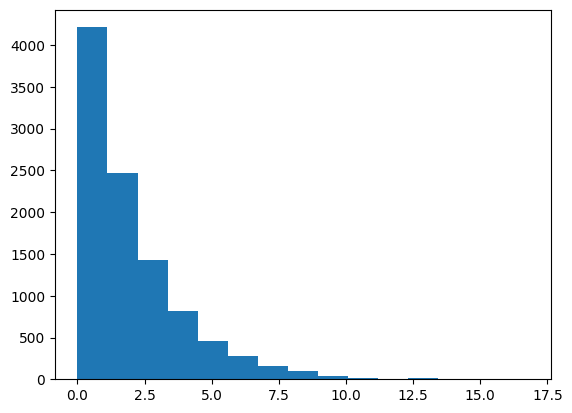

In [10]:
c, b = exponential.generate_n(N)
plt.stairs(c, b, fill=True)

In [11]:
chi2, df, t = chi2_exp(b, c)
display(t)

chi2_crit = scipy.stats.chi2.isf(ALPHA, df=df, loc=0, scale=1)
print(f"chi2 = {chi2}")
print(f"df = {df}")
print(f"chi2_crit = {chi2_crit}")
print(f"Гипотезу {'принимаем' if chi2 < chi2_crit else 'отвергаем'}")

,i,n_i,n'_i,n_i - n'_i,(n_i - n'_i)^2,K
0,0.559756,4213,4189.393318,23.606682,557.275435,0.133021
1,1.679210,2466,2434.267335,31.732665,1006.962024,0.413661
2,2.798665,1425,1414.442858,10.557142,111.453244,0.078797
3,3.918119,816,821.868893,-5.868893,34.443900,0.041909
4,5.037574,456,477.550912,-21.550912,464.441800,0.972549
5,6.157028,284,277.483277,6.516723,42.467682,0.153046
6,7.276483,156,161.233006,-5.233006,27.384348,0.169843
7,8.395937,98,93.685221,4.314779,18.617317,0.198722
8,9.515392,39,54.436253,-15.436253,238.277898,4.377191
9,10.634846,20,31.630449,-11.630449,135.267345,4.276491


chi2 = 17.205243617407714
df = 11
chi2_crit = 19.67513757268249
Гипотезу принимаем
